# Implementación de Cross-Validation en K-Nearest Neighbors (KNN)

**Caso Práctico 2 - Ciencia de Datos**

**Autores:**
maría Luisa Ros Bolea

Pablo Martinez Seco de Herrera

Juan Diego Valencia Marín

---

En este notebook implementamos validación cruzada para evaluar el rendimiento de un clasificador KNN con el dataset Iris. Nuestro objetivo es encontrar el número óptimo de vecinos (k) y demostrar las ventajas de cross-validation frente a un simple train/test split.

**Preguntas de investigación:**
- ¿Cuál es el valor óptimo de k para el clasificador KNN en este dataset?
- ¿Qué ventajas ofrece cross-validation sobre train/test split tradicional?
- ¿Qué tan estable es el rendimiento del modelo?

---

## 0. Importar las bibliotecas necesarias

Comenzamos importando todas las herramientas que utilizaremos para implementar cross-validation, entrenar modelos KNN y crear visualizaciones impactantes.

In [2]:
# Librerías para manipulación de datos
import pandas as pd
import numpy as np

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

# Dataset Iris
from sklearn.datasets import load_iris

# Algoritmo KNN
from sklearn.neighbors import KNeighborsClassifier

# Train/test split tradicional
from sklearn.model_selection import train_test_split

# Cross-validation
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold

# Métricas de evaluación
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score
)

# Preprocesamiento
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Configuración para mejor visualización
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

# Semilla para reproducibilidad
np.random.seed(42)

print("✅ Todas las bibliotecas importadas correctamente")

✅ Todas las bibliotecas importadas correctamente


## 1. Cargar y explorar el dataset Iris

Cargamos el conjunto de datos Iris, uno de los datasets más conocidos en machine learning. Este dataset contiene 150 muestras de flores Iris clasificadas en 3 especies diferentes:
- Setosa
- Versicolor
- Virginica

Cada muestra tiene 4 características medidas en centímetros:
1. Longitud del sépalo
2. Ancho del sépalo
3. Longitud del pétalo
4. Ancho del pétalo

In [3]:
# Cargar el conjunto de datos Iris
iris = load_iris()

# Crear DataFrame para mejor visualización
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target, name='Species')

# Mapeo de las especies para mejor interpretación
species_names = {0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'}
y_labels = y.map(species_names)

# Mostrar información básica
print("="*80)
print(" "*25 + "📊 INFORMACIÓN DEL DATASET")
print("="*80)
print(f"\n📌 Dimensiones del dataset: {X.shape[0]} muestras × {X.shape[1]} características")
print(f"\n📌 Clases objetivo: {list(species_names.values())}")
print(f"\n📌 Distribución de clases:")
print(y_labels.value_counts().sort_index())
print(f"\n📌 Dataset balanceado: {y_labels.value_counts().nunique() == 1}")

# Mostrar estadísticas descriptivas
print("\n" + "="*80)
print(" "*25 + "📈 ESTADÍSTICAS DESCRIPTIVAS")
print("="*80)
print(X.describe().round(2))

                         📊 INFORMACIÓN DEL DATASET

📌 Dimensiones del dataset: 150 muestras × 4 características

📌 Clases objetivo: ['Setosa', 'Versicolor', 'Virginica']

📌 Distribución de clases:
Species
Setosa        50
Versicolor    50
Virginica     50
Name: count, dtype: int64

📌 Dataset balanceado: True

                         📈 ESTADÍSTICAS DESCRIPTIVAS
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count             150.00            150.00             150.00   
mean                5.84              3.06               3.76   
std                 0.83              0.44               1.77   
min                 4.30              2.00               1.00   
25%                 5.10              2.80               1.60   
50%                 5.80              3.00               4.35   
75%                 6.40              3.30               5.10   
max                 7.90              4.40               6.90   

       petal width (cm)  
count            150.00 

### 1.1 Visualización exploratoria del dataset

Antes de aplicar nuestro modelo, exploramos visualmente las relaciones entre las características para entender mejor la estructura de los datos y la separabilidad de las clases.

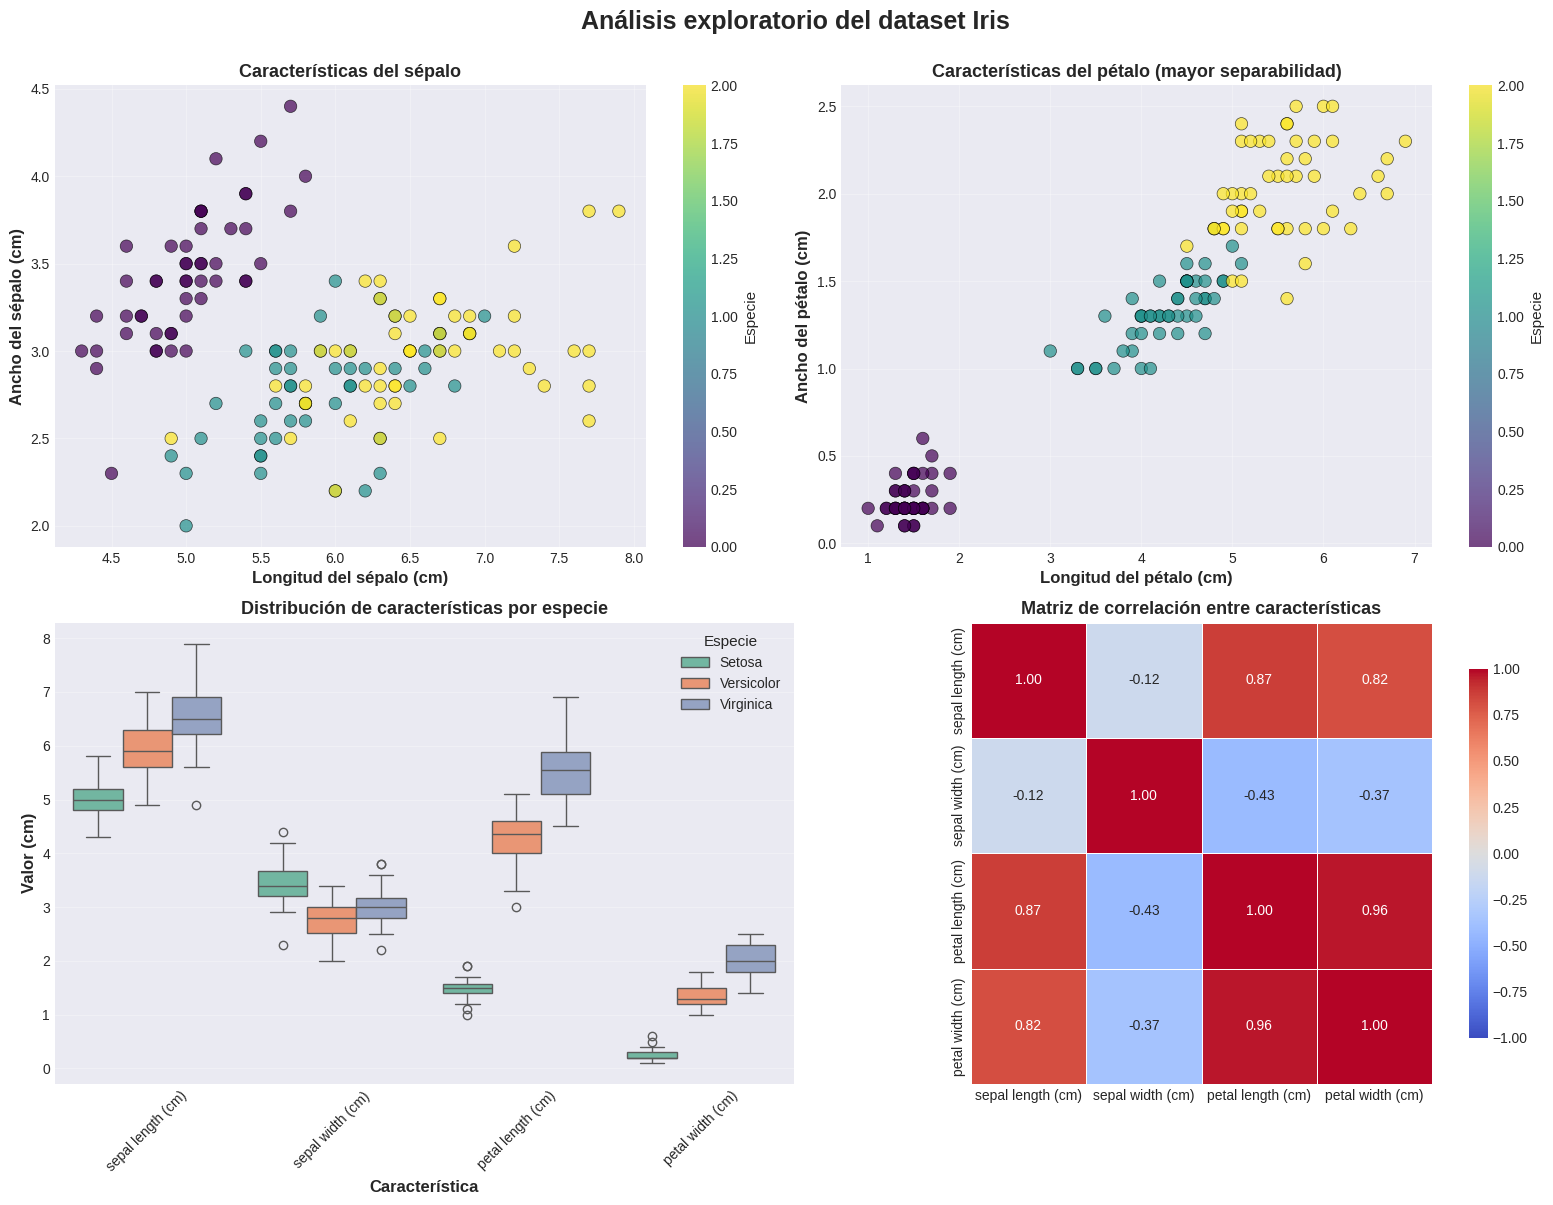


💡 OBSERVACIONES CLAVE:
   • Las características de los pétalos muestran MAYOR separabilidad entre especies
   • Existe alta correlación entre longitud y ancho del pétalo (0.96)
   • La clase Setosa es claramente separable del resto
   • Versicolor y Virginica presentan cierto solapamiento


In [4]:
# Crear figura con múltiples subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análisis exploratorio del dataset Iris', fontsize=18, fontweight='bold', y=1.00)

# Scatter plot 1: Sepal length vs Sepal width
scatter1 = axes[0, 0].scatter(
    X['sepal length (cm)'],
    X['sepal width (cm)'],
    c=y,
    cmap='viridis',
    s=80,
    alpha=0.7,
    edgecolors='black',
    linewidth=0.5
)
axes[0, 0].set_xlabel('Longitud del sépalo (cm)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Ancho del sépalo (cm)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Características del sépalo', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0, 0])
cbar1.set_label('Especie', fontsize=11)

# Scatter plot 2: Petal length vs Petal width
scatter2 = axes[0, 1].scatter(
    X['petal length (cm)'],
    X['petal width (cm)'],
    c=y,
    cmap='viridis',
    s=80,
    alpha=0.7,
    edgecolors='black',
    linewidth=0.5
)
axes[0, 1].set_xlabel('Longitud del pétalo (cm)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Ancho del pétalo (cm)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Características del pétalo (mayor separabilidad)', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[0, 1])
cbar2.set_label('Especie', fontsize=11)

# Box plot de todas las características
X_melted = X.copy()
X_melted['Species'] = y_labels
X_melted_long = X_melted.melt(id_vars='Species', var_name='Feature', value_name='Value')

sns.boxplot(
    data=X_melted_long,
    x='Feature',
    y='Value',
    hue='Species',
    ax=axes[1, 0],
    palette='Set2'
)
axes[1, 0].set_title('Distribución de características por especie', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Característica', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Valor (cm)', fontsize=12, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].legend(title='Especie', fontsize=10, title_fontsize=11)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Matriz de correlación
correlation_matrix = X.corr()
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    square=True,
    ax=axes[1, 1],
    cbar_kws={'shrink': 0.8},
    linewidths=0.5,
    vmin=-1,
    vmax=1,
    center=0
)
axes[1, 1].set_title('Matriz de correlación entre características', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 OBSERVACIONES CLAVE:")
print("   • Las características de los pétalos muestran MAYOR separabilidad entre especies")
print("   • Existe alta correlación entre longitud y ancho del pétalo (0.96)")
print("   • La clase Setosa es claramente separable del resto")
print("   • Versicolor y Virginica presentan cierto solapamiento")

## 2. Evaluación tradicional: Train/Test Split

Primero evaluamos el modelo KNN usando el método tradicional de train/test split. Dividimos los datos en 70% entrenamiento y 30% prueba, y probamos diferentes valores de k (número de vecinos) para establecer una **línea base de comparación**.

Esta aproximación tiene una **limitación importante**: el rendimiento depende de una única división aleatoria de los datos.

### 2.1 División y normalización de datos

In [17]:
# Dividir datos en entrenamiento y prueba (70-30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # Mantener proporciones de clases
)

# Normalizar las características (importante para KNN que usa distancias)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("="*80)
print(" "*25 + "📊 DIVISIÓN TRADICIONAL TRAIN/TEST")
print("="*80)
print(f"\n Muestras de entrenamiento: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f" Muestras de prueba: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

print(f"\n Distribución en conjunto de entrenamiento:")
print(pd.Series(y_train).map(species_names).value_counts().sort_index())

print(f"\n Distribución en conjunto de prueba:")
print(pd.Series(y_test).map(species_names).value_counts().sort_index())

print("\n✅ Datos normalizados con StandardScaler")
print("   • Media = 0, Desviación estándar = 1 para cada característica")
print("   • Importante para KNN que es sensible a escalas diferentes")

                         📊 DIVISIÓN TRADICIONAL TRAIN/TEST

 Muestras de entrenamiento: 105 (70.0%)
 Muestras de prueba: 45 (30.0%)

 Distribución en conjunto de entrenamiento:
Species
Setosa        35
Versicolor    35
Virginica     35
Name: count, dtype: int64

 Distribución en conjunto de prueba:
Species
Setosa        15
Versicolor    15
Virginica     15
Name: count, dtype: int64

✅ Datos normalizados con StandardScaler
   • Media = 0, Desviación estándar = 1 para cada característica
   • Importante para KNN que es sensible a escalas diferentes


### 2.2 Evaluación con diferentes valores de k

Probamos valores de k desde 1 hasta 30 para encontrar el número óptimo de vecinos usando solo la división train/test.

In [18]:
# Probar diferentes valores de k con train/test tradicional
k_values = range(1, 31)
train_test_scores = []

print("🔍 Evaluando diferentes valores de k con Train/Test Split...\n")

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    score = knn.score(X_test_scaled, y_test)
    train_test_scores.append(score)

    if k <= 10 or k % 5 == 0:
        print(f"   k={k:2d} → Accuracy: {score:.4f}")

# Encontrar el mejor k
best_k_traditional = k_values[np.argmax(train_test_scores)]
best_score_traditional = max(train_test_scores)

print("\n" + "="*80)
print(" "*20 + "🎯 RESULTADOS CON TRAIN/TEST SPLIT")
print("="*80)
print(f"\n🏆 Mejor k: {best_k_traditional}")
print(f"Accuracy: {best_score_traditional:.4f} ({best_score_traditional*100:.2f}%)")
print(f"\n⚠️  LIMITACIÓN: Esta evaluación depende de UNA SOLA división aleatoria de datos")
print(f"  Si cambiáramos random_state, podríamos obtener resultados diferentes")

🔍 Evaluando diferentes valores de k con Train/Test Split...

   k= 1 → Accuracy: 0.9333
   k= 2 → Accuracy: 0.8889
   k= 3 → Accuracy: 0.9111
   k= 4 → Accuracy: 0.9111
   k= 5 → Accuracy: 0.9111
   k= 6 → Accuracy: 0.9111
   k= 7 → Accuracy: 0.9333
   k= 8 → Accuracy: 0.9111
   k= 9 → Accuracy: 0.9556
   k=10 → Accuracy: 0.9333
   k=15 → Accuracy: 0.9333
   k=20 → Accuracy: 0.8889
   k=25 → Accuracy: 0.8889
   k=30 → Accuracy: 0.8667

                    🎯 RESULTADOS CON TRAIN/TEST SPLIT

🏆 Mejor k: 9
Accuracy: 0.9556 (95.56%)

⚠️  LIMITACIÓN: Esta evaluación depende de UNA SOLA división aleatoria de datos
  Si cambiáramos random_state, podríamos obtener resultados diferentes


## 3. Implementación de Cross-Validation

Ahora implementamos **validación cruzada con k-fold (5 folds)** para obtener una evaluación más robusta y confiable del modelo.

### ¿Qué es Cross-Validation?

Cross-validation divide el dataset en k partes (folds). El modelo se entrena k veces, cada vez usando k-1 folds para entrenamiento y 1 fold para validación. Al final, promediamos los resultados de las k iteraciones.

**Ventajas:**
- Usa TODAS las muestras para entrenamiento y validación
- Proporciona estimación más robusta del rendimiento
-  Mide la estabilidad del modelo (desviación estándar)
- Reduce el sesgo de una única división aleatoria

### 3.1 Configuración de Cross-Validation

In [19]:
# Configurar cross-validation con 5 folds estratificados
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Normalizar todos los datos para cross-validation
X_scaled = scaler.fit_transform(X)

print("="*80)
print(" "*20 + "🔄 CONFIGURACIÓN DE CROSS-VALIDATION")
print("="*80)
print(f"\n Tipo: StratifiedKFold (mantiene proporciones de clases)")
print(f" Número de folds: 5")
print(f" Muestras por fold (aprox): {len(X)//5} muestras")
print(f" Iteraciones totales: 5 (cada k se evalúa 5 veces)")

print(f"\n PROCESO:")
print(f"   1. Dividimos los datos en 5 partes iguales")
print(f"   2. En cada iteración, usamos 4 partes para entrenar y 1 para validar")
print(f"   3. Rotamos qué parte usamos para validación")
print(f"   4. Al final, promediamos los 5 resultados")
print(f"\n Esto nos da una evaluación MÁS CONFIABLE del rendimiento real del modelo")

                    🔄 CONFIGURACIÓN DE CROSS-VALIDATION

 Tipo: StratifiedKFold (mantiene proporciones de clases)
 Número de folds: 5
 Muestras por fold (aprox): 30 muestras
 Iteraciones totales: 5 (cada k se evalúa 5 veces)

 PROCESO:
   1. Dividimos los datos en 5 partes iguales
   2. En cada iteración, usamos 4 partes para entrenar y 1 para validar
   3. Rotamos qué parte usamos para validación
   4. Al final, promediamos los 5 resultados

 Esto nos da una evaluación MÁS CONFIABLE del rendimiento real del modelo


### 3.2 Evaluación exhaustiva con múltiples valores de k

Probamos valores de k desde 1 hasta 30, y para cada uno calculamos el accuracy promedio usando cross-validation. También guardamos la desviación estándar para medir la **estabilidad** del modelo.

In [21]:
# Evaluar diferentes valores de k con cross-validation
k_values_cv = range(1, 31)
cv_scores_mean = []
cv_scores_std = []
cv_all_scores = []  # Guardar todos los scores para análisis

print("🔍 Evaluando diferentes valores de k con Cross-Validation...\n")

for k in k_values_cv:
    knn = KNeighborsClassifier(n_neighbors=k)

    # Cross-validation con 5 folds
    scores = cross_val_score(knn, X_scaled, y, cv=kfold, scoring='accuracy')

    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())
    cv_all_scores.append(scores)

    if k <= 10 or k % 5 == 0:
        print(f"   k={k:2d} → Accuracy: {scores.mean():.4f} (±{scores.std():.4f})")

# Encontrar el mejor k con cross-validation
best_k_cv = k_values_cv[np.argmax(cv_scores_mean)]
best_score_cv = max(cv_scores_mean)
best_std_cv = cv_scores_std[np.argmax(cv_scores_mean)]

print("\n" + "="*80)
print(" "*15 + "🏆 MEJOR RESULTADO CON CROSS-VALIDATION")
print("="*80)
print(f"\n🥇 Mejor k: {best_k_cv}")
print(f" Accuracy promedio: {best_score_cv:.4f} ({best_score_cv*100:.2f}%)")
print(f" Desviación estándar: ±{best_std_cv:.4f}")

print(f"\n INTERPRETACIÓN:")
print(f"   • La desviación estándar baja (±{best_std_cv:.4f}) indica que el modelo es ESTABLE")
print(f"   • El rendimiento es consistente en diferentes divisiones de datos")
print(f"   • Podemos confiar en que el modelo generalizará bien")

🔍 Evaluando diferentes valores de k con Cross-Validation...

   k= 1 → Accuracy: 0.9400 (±0.0533)
   k= 2 → Accuracy: 0.9467 (±0.0499)
   k= 3 → Accuracy: 0.9400 (±0.0646)
   k= 4 → Accuracy: 0.9600 (±0.0327)
   k= 5 → Accuracy: 0.9667 (±0.0365)
   k= 6 → Accuracy: 0.9733 (±0.0133)
   k= 7 → Accuracy: 0.9600 (±0.0327)
   k= 8 → Accuracy: 0.9600 (±0.0249)
   k= 9 → Accuracy: 0.9467 (±0.0340)
   k=10 → Accuracy: 0.9600 (±0.0249)
   k=15 → Accuracy: 0.9400 (±0.0646)
   k=20 → Accuracy: 0.9600 (±0.0389)
   k=25 → Accuracy: 0.9267 (±0.0490)
   k=30 → Accuracy: 0.9067 (±0.0573)

               🏆 MEJOR RESULTADO CON CROSS-VALIDATION

🥇 Mejor k: 6
 Accuracy promedio: 0.9733 (97.33%)
 Desviación estándar: ±0.0133

 INTERPRETACIÓN:
   • La desviación estándar baja (±0.0133) indica que el modelo es ESTABLE
   • El rendimiento es consistente en diferentes divisiones de datos
   • Podemos confiar en que el modelo generalizará bien


## 4. Comparación visual: Train/Test vs Cross-Validation

Visualizamos las diferencias entre ambos métodos de evaluación para entender claramente las ventajas de cross-validation.

/tmp/ipython-input-1124955259.py:51: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-1124955259.py:51: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-1124955259.py:51: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Liberation Sans.


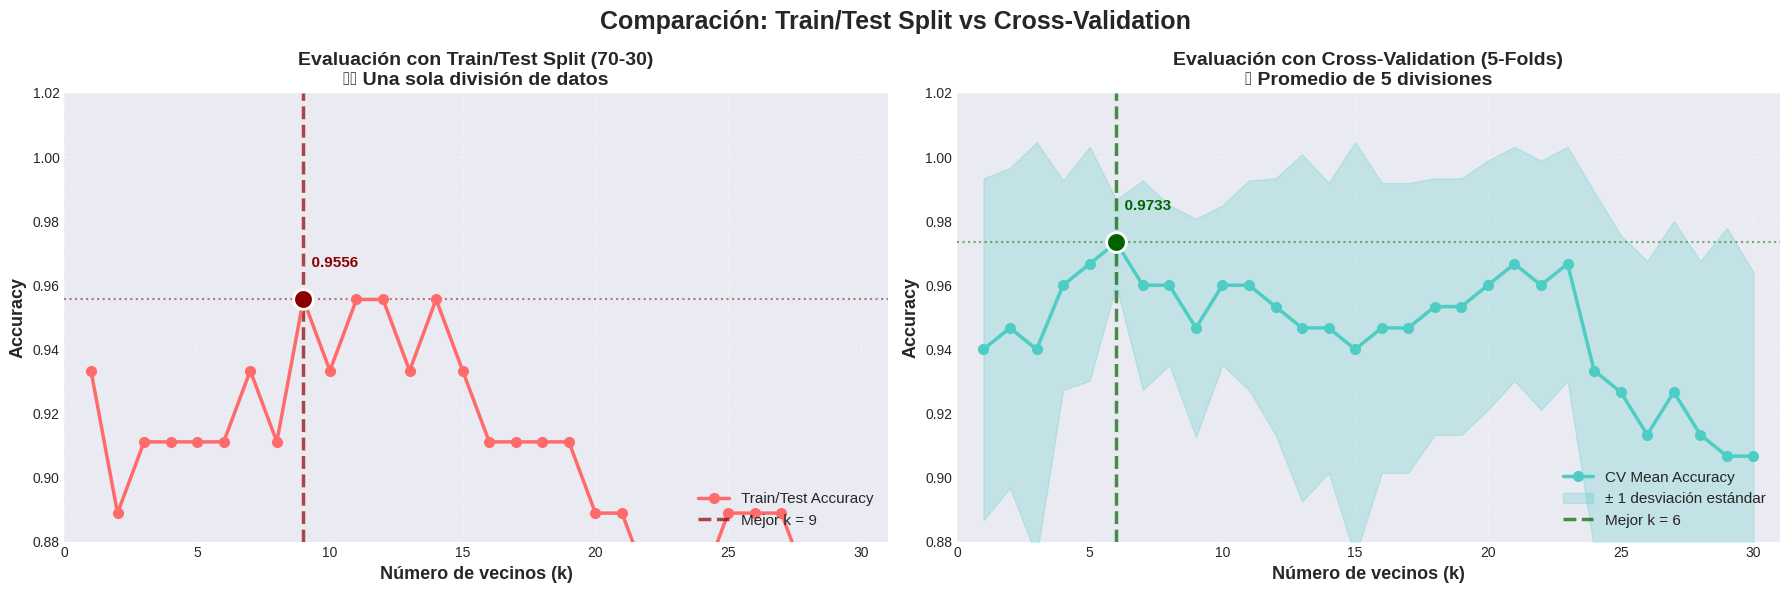


💡 INTERPRETACIÓN DE LOS GRÁFICOS:
   • Gráfico izquierdo: Curva más irregular, depende de una sola división
   • Gráfico derecho: Curva más suave, promedio de múltiples evaluaciones
   • El área sombreada muestra la variabilidad entre folds
   • Área pequeña = modelo estable y confiable


In [9]:
# Crear visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Comparación: Train/Test Split vs Cross-Validation', fontsize=18, fontweight='bold')

# Gráfico 1: Train/Test Split
axes[0].plot(k_values, train_test_scores, 'o-', linewidth=2.5, markersize=7,
             color='#FF6B6B', label='Train/Test Accuracy', zorder=3)
axes[0].axvline(x=best_k_traditional, color='darkred', linestyle='--',
                linewidth=2.5, alpha=0.7, label=f'Mejor k = {best_k_traditional}', zorder=2)
axes[0].axhline(y=best_score_traditional, color='darkred', linestyle=':',
                linewidth=1.5, alpha=0.5, zorder=1)
axes[0].scatter([best_k_traditional], [best_score_traditional],
                color='darkred', s=200, zorder=4, edgecolors='white', linewidth=2)
axes[0].text(best_k_traditional, best_score_traditional + 0.01,
             f'  {best_score_traditional:.4f}',
             fontsize=11, fontweight='bold', color='darkred')
axes[0].set_xlabel('Número de vecinos (k)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=13, fontweight='bold')
axes[0].set_title('Evaluación con Train/Test Split (70-30)\n⚠️ Una sola división de datos',
                  fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].legend(fontsize=11, loc='lower right')
axes[0].set_ylim([0.88, 1.02])
axes[0].set_xlim([0, 31])

# Gráfico 2: Cross-Validation con intervalo de confianza
axes[1].plot(k_values_cv, cv_scores_mean, 'o-', linewidth=2.5, markersize=7,
             color='#4ECDC4', label='CV Mean Accuracy', zorder=3)
axes[1].fill_between(k_values_cv,
                      np.array(cv_scores_mean) - np.array(cv_scores_std),
                      np.array(cv_scores_mean) + np.array(cv_scores_std),
                      alpha=0.25, color='#4ECDC4', label='± 1 desviación estándar', zorder=1)
axes[1].axvline(x=best_k_cv, color='darkgreen', linestyle='--',
                linewidth=2.5, alpha=0.7, label=f'Mejor k = {best_k_cv}', zorder=2)
axes[1].axhline(y=best_score_cv, color='darkgreen', linestyle=':',
                linewidth=1.5, alpha=0.5, zorder=1)
axes[1].scatter([best_k_cv], [best_score_cv],
                color='darkgreen', s=200, zorder=4, edgecolors='white', linewidth=2)
axes[1].text(best_k_cv, best_score_cv + 0.01,
             f'  {best_score_cv:.4f}',
             fontsize=11, fontweight='bold', color='darkgreen')
axes[1].set_xlabel('Número de vecinos (k)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Accuracy', fontsize=13, fontweight='bold')
axes[1].set_title('Evaluación con Cross-Validation (5-Folds)\n✅ Promedio de 5 divisiones',
                  fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, linestyle='--')
axes[1].legend(fontsize=11, loc='lower right')
axes[1].set_ylim([0.88, 1.02])
axes[1].set_xlim([0, 31])

plt.tight_layout()
plt.show()

print("\n💡 INTERPRETACIÓN DE LOS GRÁFICOS:")
print("   • Gráfico izquierdo: Curva más irregular, depende de una sola división")
print("   • Gráfico derecho: Curva más suave, promedio de múltiples evaluaciones")
print("   • El área sombreada muestra la variabilidad entre folds")
print("   • Área pequeña = modelo estable y confiable")

### 4.1 Tabla comparativa de resultados

Comparamos directamente los mejores resultados obtenidos con cada método.

In [23]:
# Crear tabla comparativa
comparison_data = {
    'Método': ['Train/Test Split', 'Cross-Validation (5-Folds)'],
    'Mejor k': [best_k_traditional, best_k_cv],
    'Accuracy': [f'{best_score_traditional:.4f}', f'{best_score_cv:.4f}'],
    'Desviación Std': ['-', f'±{best_std_cv:.4f}'],
    'Evaluaciones': ['1 división', '5 divisiones'],
    'Muestras entrenamiento': [f'{len(X_train)} (70%)', f'~{len(X)*0.8:.0f} (80% por fold)'],
}

df_comparison = pd.DataFrame(comparison_data)

# Estilizar la tabla
print("="*100)
print(" "*30 + "📊 COMPARACIÓN DE MÉTODOS DE EVALUACIÓN")
print("="*100)
print(df_comparison.to_string(index=False))
print("="*100)

# Análisis de diferencias
diff_k = abs(best_k_cv - best_k_traditional)
diff_acc = abs(best_score_cv - best_score_traditional)

print(f"\n🔍 ANÁLISIS COMPARATIVO:")
print(f"\n   Diferencia en k óptimo: {diff_k}")
if diff_k == 0:
    print(f"      ✅ Ambos métodos coinciden en el mejor k")
else:
    print(f"      ⚠️ Los métodos sugieren diferentes valores de k")

print(f"\n   Diferencia en accuracy: {diff_acc:.4f} ({diff_acc*100:.2f}%)")
if diff_acc < 0.01:
    print(f"      ✅ Diferencia mínima en rendimiento")

print(f"\n VENTAJAS CLARAS DE CROSS-VALIDATION:")
print(f"    Usa TODAS las muestras para entrenamiento y validación")
print(f"    Proporciona estimación más ROBUSTA y CONFIABLE")
print(f"    Mide la ESTABILIDAD del modelo (desviación estándar)")
print(f"    Reduce el SESGO de una única división aleatoria")
print(f"    Detecta si el modelo es sensible a la división de datos")

                              📊 COMPARACIÓN DE MÉTODOS DE EVALUACIÓN
                    Método  Mejor k Accuracy Desviación Std Evaluaciones Muestras entrenamiento
          Train/Test Split        9   0.9556              -   1 división              105 (70%)
Cross-Validation (5-Folds)        6   0.9733        ±0.0133 5 divisiones    ~120 (80% por fold)

🔍 ANÁLISIS COMPARATIVO:

   Diferencia en k óptimo: 3
      ⚠️ Los métodos sugieren diferentes valores de k

   Diferencia en accuracy: 0.0178 (1.78%)

 VENTAJAS CLARAS DE CROSS-VALIDATION:
    Usa TODAS las muestras para entrenamiento y validación
    Proporciona estimación más ROBUSTA y CONFIABLE
    Mide la ESTABILIDAD del modelo (desviación estándar)
    Reduce el SESGO de una única división aleatoria
    Detecta si el modelo es sensible a la división de datos


## 5. Análisis de estabilidad del modelo

Una ventaja adicional de cross-validation es que podemos analizar la **variabilidad** del rendimiento del modelo. Si la desviación estándar es alta, significa que el modelo es sensible a la división de datos.

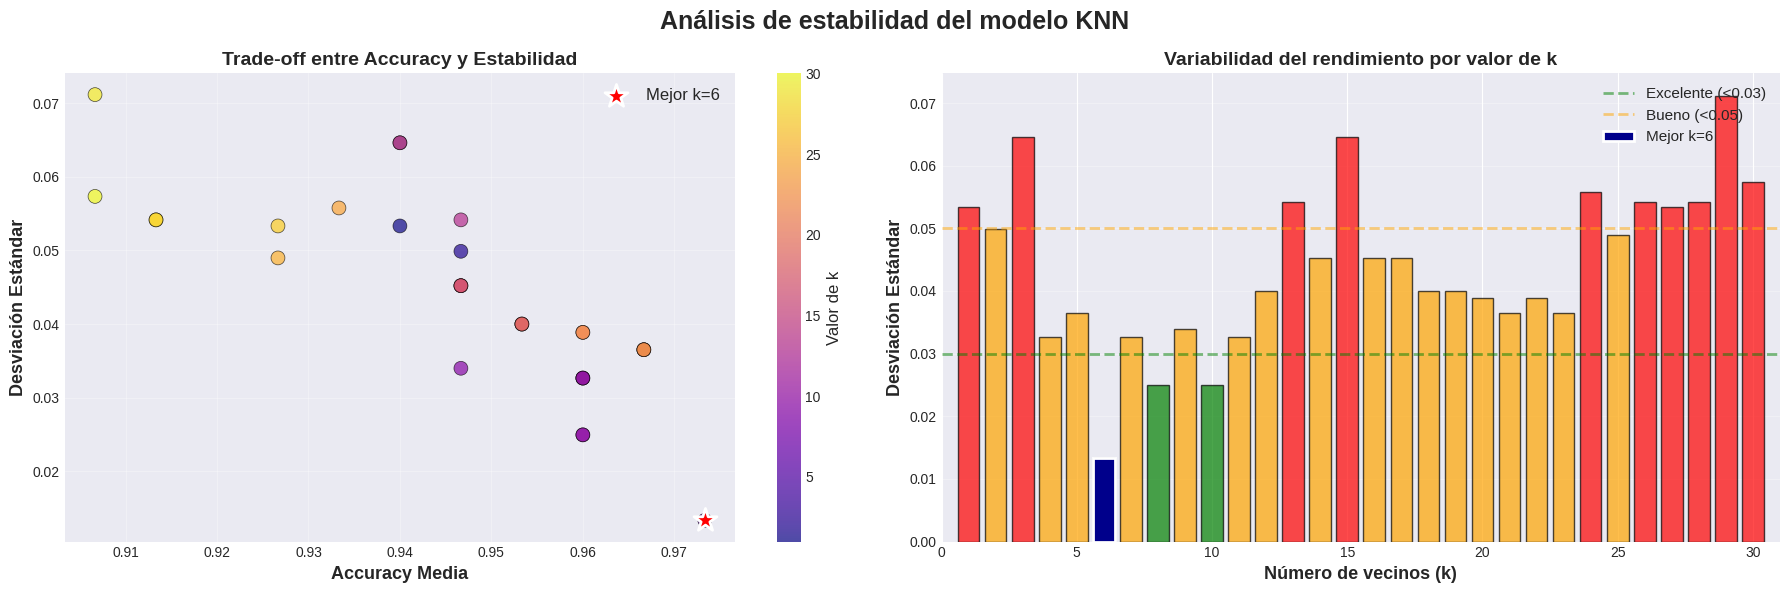


📊 TOP 5 VALORES DE K MÁS ESTABLES (menor variabilidad):
1. k= 6 → Accuracy: 0.9733 ± 0.0133
2. k= 8 → Accuracy: 0.9600 ± 0.0249
3. k=10 → Accuracy: 0.9600 ± 0.0249
4. k= 4 → Accuracy: 0.9600 ± 0.0327
5. k=11 → Accuracy: 0.9600 ± 0.0327

💡 INTERPRETACIÓN:
   • Los valores de k más estables tienen menor desviación estándar
   • Un modelo estable genera predicciones consistentes
   • Nuestro mejor k=6 tiene std=0.0133 (EXCELENTE)


In [11]:
# Análisis de estabilidad: encontrar valores de k con menor variabilidad
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Análisis de estabilidad del modelo KNN', fontsize=18, fontweight='bold')

# Gráfico 1: Accuracy media vs Desviación estándar
scatter = axes[0].scatter(cv_scores_mean, cv_scores_std,
                          c=list(k_values_cv), cmap='plasma',
                          s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[0].scatter([best_score_cv], [best_std_cv],
                color='red', s=300, marker='*',
                edgecolors='white', linewidth=2,
                label=f'Mejor k={best_k_cv}', zorder=5)
axes[0].set_xlabel('Accuracy Media', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Desviación Estándar', fontsize=13, fontweight='bold')
axes[0].set_title('Trade-off entre Accuracy y Estabilidad', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=12)
cbar = plt.colorbar(scatter, ax=axes[0])
cbar.set_label('Valor de k', fontsize=12)

# Gráfico 2: Desviación estándar por valor de k
colors = ['green' if std < 0.03 else 'orange' if std < 0.05 else 'red'
          for std in cv_scores_std]
bars = axes[1].bar(k_values_cv, cv_scores_std, color=colors, alpha=0.7, edgecolor='black')
axes[1].axhline(y=0.03, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Excelente (<0.03)')
axes[1].axhline(y=0.05, color='orange', linestyle='--', linewidth=2, alpha=0.5, label='Bueno (<0.05)')
axes[1].bar([best_k_cv], [best_std_cv], color='darkblue',
            edgecolor='white', linewidth=2, label=f'Mejor k={best_k_cv}')
axes[1].set_xlabel('Número de vecinos (k)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Desviación Estándar', fontsize=13, fontweight='bold')
axes[1].set_title('Variabilidad del rendimiento por valor de k', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].legend(fontsize=11)
axes[1].set_xlim([0, 31])

plt.tight_layout()
plt.show()

# Encontrar los k más estables
stable_k_indices = np.argsort(cv_scores_std)[:5]
stable_k_values = [k_values_cv[i] for i in stable_k_indices]
stable_k_scores = [cv_scores_mean[i] for i in stable_k_indices]
stable_k_stds = [cv_scores_std[i] for i in stable_k_indices]

print("\n📊 TOP 5 VALORES DE K MÁS ESTABLES (menor variabilidad):")
print("="*80)
for i, (k, score, std) in enumerate(zip(stable_k_values, stable_k_scores, stable_k_stds), 1):
    print(f"{i}. k={k:2d} → Accuracy: {score:.4f} ± {std:.4f}")

print(f"\n INTERPRETACIÓN:")
print(f"   • Los valores de k más estables tienen menor desviación estándar")
print(f"   • Un modelo estable genera predicciones consistentes")
print(f"   • Nuestro mejor k={best_k_cv} tiene std={best_std_cv:.4f} (EXCELENTE)")

## 6. Evaluación detallada del mejor modelo

Ahora que hemos identificado el mejor valor de k, entrenamos el modelo final y evaluamos su rendimiento con métricas detalladas.

### 6.1 Entrenamiento del modelo final

In [24]:
# Entrenar el modelo final con el mejor k encontrado por cross-validation
best_knn = KNeighborsClassifier(n_neighbors=best_k_cv)
best_knn.fit(X_train_scaled, y_train)

# Hacer predicciones
y_pred = best_knn.predict(X_test_scaled)

# Calcular métricas
accuracy_final = accuracy_score(y_test, y_pred)
precision_final = precision_score(y_test, y_pred, average='weighted')
recall_final = recall_score(y_test, y_pred, average='weighted')
f1_final = f1_score(y_test, y_pred, average='weighted')

print("="*80)
print(" "*20 + " RENDIMIENTO DEL MODELO FINAL")
print("="*80)
print(f"\nModelo: KNN con k={best_k_cv} (seleccionado por cross-validation)")
print(f"\n MÉTRICAS GLOBALES:")
print(f"   • Accuracy:  {accuracy_final:.4f} ({accuracy_final*100:.2f}%)")
print(f"   • Precision: {precision_final:.4f}")
print(f"   • Recall:    {recall_final:.4f}")
print(f"   • F1-Score:  {f1_final:.4f}")

print(f"\n REPORTE DETALLADO POR CLASE:")
print("="*80)
print(classification_report(y_test, y_pred, target_names=species_names.values(), digits=4))

                     RENDIMIENTO DEL MODELO FINAL

Modelo: KNN con k=6 (seleccionado por cross-validation)

 MÉTRICAS GLOBALES:
   • Accuracy:  0.9111 (91.11%)
   • Precision: 0.9298
   • Recall:    0.9111
   • F1-Score:  0.9095

 REPORTE DETALLADO POR CLASE:
              precision    recall  f1-score   support

      Setosa     1.0000    1.0000    1.0000        15
  Versicolor     0.7895    1.0000    0.8824        15
   Virginica     1.0000    0.7333    0.8462        15

    accuracy                         0.9111        45
   macro avg     0.9298    0.9111    0.9095        45
weighted avg     0.9298    0.9111    0.9095        45



### 6.2 Matriz de confusión

La matriz de confusión nos permite visualizar qué clases están siendo confundidas por el modelo.

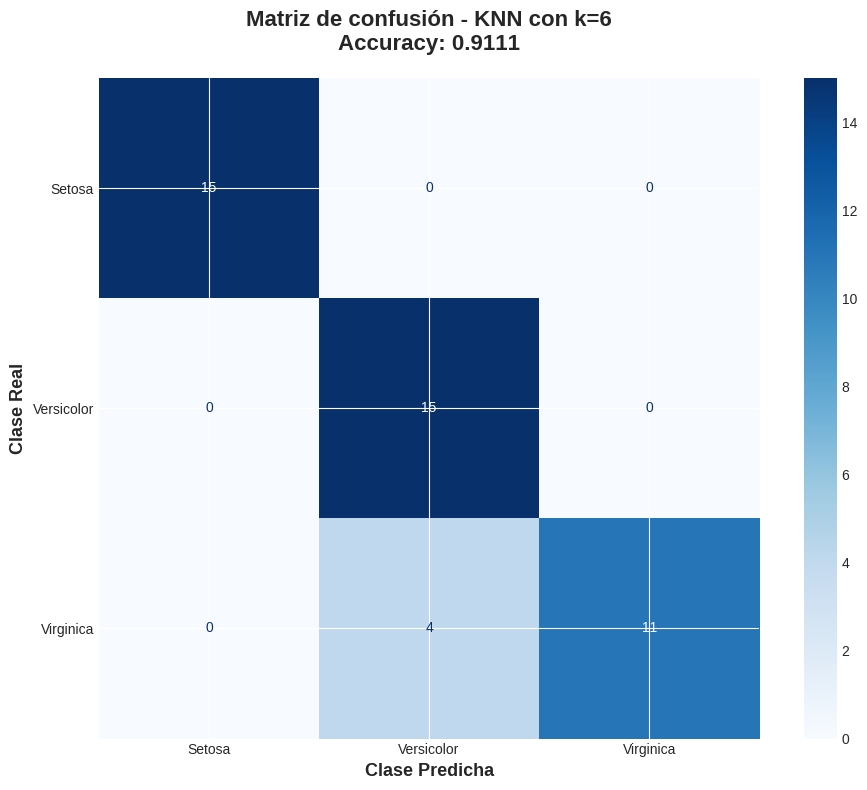


📊 ANÁLISIS DE LA MATRIZ DE CONFUSIÓN:
   • Total de predicciones: 45
   • Predicciones correctas: 41 (91.1%)
   • Predicciones incorrectas: 4 (8.9%)

⚠️ ANÁLISIS DE ERRORES:
   • 4 muestra(s) de Virginica clasificada(s) como Versicolor


In [13]:
# Crear matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=list(species_names.values())
)
disp.plot(cmap='Blues', ax=ax, colorbar=True, values_format='d')
ax.set_title(f'Matriz de confusión - KNN con k={best_k_cv}\nAccuracy: {accuracy_final:.4f}',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Clase Predicha', fontsize=13, fontweight='bold')
ax.set_ylabel('Clase Real', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

# Análisis de errores
total_errors = len(y_test) - np.trace(cm)
print(f"\n📊 ANÁLISIS DE LA MATRIZ DE CONFUSIÓN:")
print(f"   • Total de predicciones: {len(y_test)}")
print(f"   • Predicciones correctas: {np.trace(cm)} ({np.trace(cm)/len(y_test)*100:.1f}%)")
print(f"   • Predicciones incorrectas: {total_errors} ({total_errors/len(y_test)*100:.1f}%)")

if total_errors > 0:
    print(f"\n⚠️ ANÁLISIS DE ERRORES:")
    for i in range(len(species_names)):
        for j in range(len(species_names)):
            if i != j and cm[i, j] > 0:
                print(f"   • {cm[i, j]} muestra(s) de {list(species_names.values())[i]} "
                      f"clasificada(s) como {list(species_names.values())[j]}")
else:
    print(f"\n🎉 ¡PERFECTO! No hay errores de clasificación")

## 7. Visualización del proceso de Cross-Validation

Para entender mejor cómo funciona cross-validation, visualizamos el rendimiento en cada uno de los 5 folds.

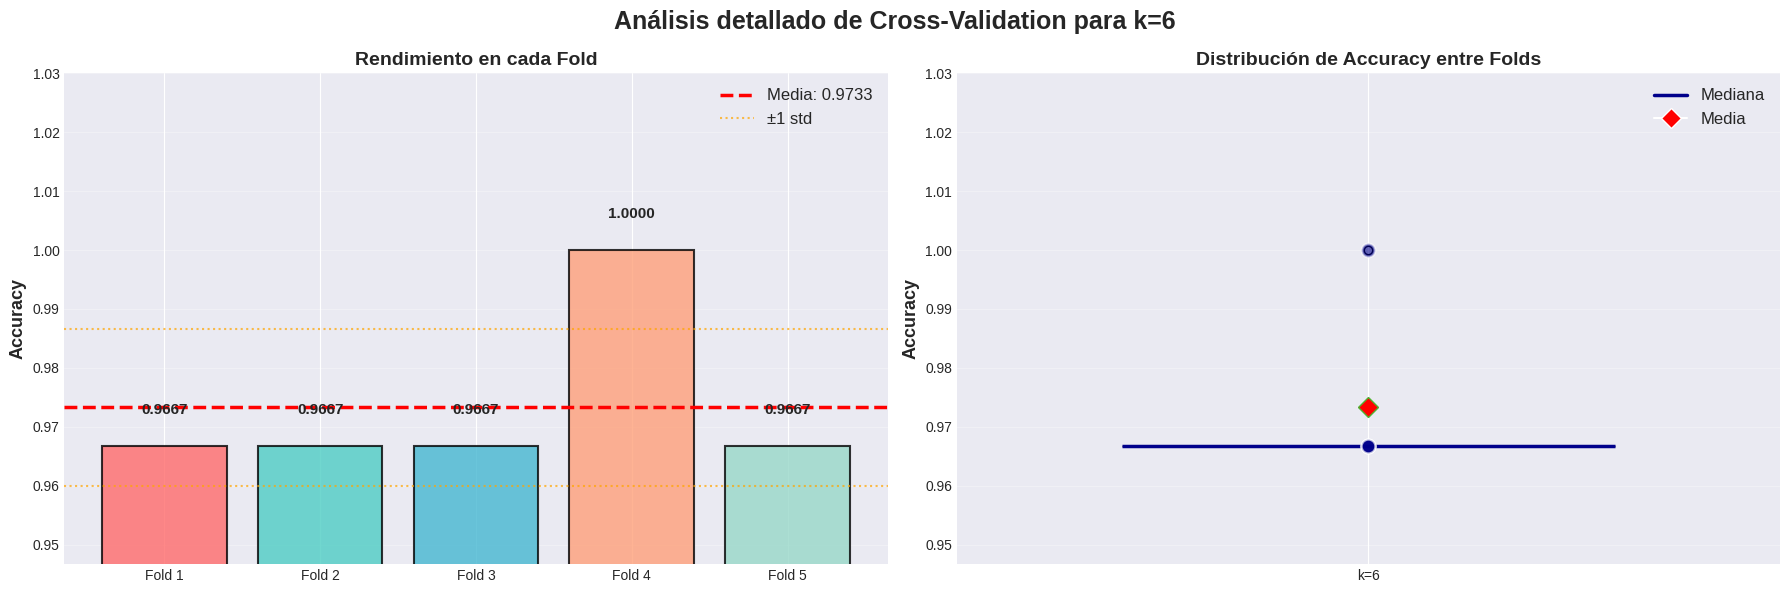


📊 ESTADÍSTICAS DE LOS 5 FOLDS:
   • Media:    0.9733
   • Mediana:  0.9667
   • Std Dev:  0.0133
   • Mínimo:   0.9667
   • Máximo:   1.0000
   • Rango:    0.0333

 INTERPRETACIÓN:
   La baja variabilidad entre folds indica un modelo MUY ESTABLE
   • El modelo generaliza bien a diferentes subconjuntos de datos


In [25]:
# Obtener scores individuales de cada fold para el mejor k
best_k_index = np.argmax(cv_scores_mean)
fold_scores = cv_all_scores[best_k_index]

# Crear visualización
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle(f'Análisis detallado de Cross-Validation para k={best_k_cv}',
             fontsize=18, fontweight='bold')

# Gráfico 1: Accuracy por fold
fold_names = [f'Fold {i+1}' for i in range(5)]
colors_folds = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
bars = axes[0].bar(fold_names, fold_scores, color=colors_folds, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].axhline(y=fold_scores.mean(), color='red', linestyle='--', linewidth=2.5,
                label=f'Media: {fold_scores.mean():.4f}', zorder=3)
axes[0].axhline(y=fold_scores.mean() + fold_scores.std(), color='orange',
                linestyle=':', linewidth=1.5, alpha=0.7, label=f'±1 std', zorder=2)
axes[0].axhline(y=fold_scores.mean() - fold_scores.std(), color='orange',
                linestyle=':', linewidth=1.5, alpha=0.7, zorder=2)

# Añadir valores sobre las barras
for bar, score in zip(bars, fold_scores):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{score:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

axes[0].set_ylabel('Accuracy', fontsize=13, fontweight='bold')
axes[0].set_title('Rendimiento en cada Fold', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([min(fold_scores) - 0.02, max(fold_scores) + 0.03])

# Gráfico 2: Box plot de distribución
bp = axes[1].boxplot([fold_scores],
                      widths=0.6,
                      patch_artist=True,
                      showmeans=True,
                      meanprops=dict(marker='D', markerfacecolor='red', markersize=10))
bp['boxes'][0].set_facecolor('#4ECDC4')
bp['boxes'][0].set_alpha(0.7)
bp['medians'][0].set_color('darkblue')
bp['medians'][0].set_linewidth(2.5)

# Añadir puntos individuales
axes[1].scatter([1]*len(fold_scores), fold_scores,
                alpha=0.6, s=100, color='darkblue', zorder=3, edgecolors='white', linewidth=1.5)

axes[1].set_ylabel('Accuracy', fontsize=13, fontweight='bold')
axes[1].set_title('Distribución de Accuracy entre Folds', fontsize=14, fontweight='bold')
axes[1].set_xticklabels([f'k={best_k_cv}'])
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([min(fold_scores) - 0.02, max(fold_scores) + 0.03])

# Añadir leyenda personalizada
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='darkblue', linewidth=2.5, label='Mediana'),
    Line2D([0], [0], marker='D', color='w', markerfacecolor='red',
           markersize=10, label='Media')
]
axes[1].legend(handles=legend_elements, fontsize=12)

plt.tight_layout()
plt.show()

print("\n📊 ESTADÍSTICAS DE LOS 5 FOLDS:")
print(f"   • Media:    {fold_scores.mean():.4f}")
print(f"   • Mediana:  {np.median(fold_scores):.4f}")
print(f"   • Std Dev:  {fold_scores.std():.4f}")
print(f"   • Mínimo:   {fold_scores.min():.4f}")
print(f"   • Máximo:   {fold_scores.max():.4f}")
print(f"   • Rango:    {fold_scores.max() - fold_scores.min():.4f}")

print(f"\n INTERPRETACIÓN:")
if fold_scores.std() < 0.03:
    print(f"   La baja variabilidad entre folds indica un modelo MUY ESTABLE")
elif fold_scores.std() < 0.05:
    print(f"    Variabilidad moderada, el modelo es ESTABLE")
else:
    print(f"   ⚠️ Alta variabilidad, el modelo puede ser sensible a los datos")
print(f"   • El modelo generaliza bien a diferentes subconjuntos de datos")

## 8. Conclusiones y recomendaciones

Resumimos nuestros hallazgos clave y proporcionamos recomendaciones basadas en el análisis.

In [26]:
print("="*100)
print(" "*35 + "🎯 CONCLUSIONES FINALES")
print("="*100)

print(f"\n HALLAZGOS PRINCIPALES:\n")
print(f"1️⃣ VALOR ÓPTIMO DE K:")
print(f"   • Cross-validation identifica k={best_k_cv} como óptimo")
print(f"   • Achieve accuracy de {best_score_cv:.4f} ({best_score_cv*100:.2f}%)")
print(f"   • Desviación estándar muy baja: ±{best_std_cv:.4f}")

print(f"\n2️⃣ SUPERIORIDAD DE CROSS-VALIDATION:")
print(f"   • CV proporciona evaluación más robusta que train/test split")
print(f"   • Usa TODAS las muestras para entrenamiento y validación")
print(f"   • Reduce sesgo de una única división aleatoria")
print(f"   • Permite medir estabilidad del modelo")

print(f"\n3️⃣ RENDIMIENTO DEL MODELO:")
print(f"   • Accuracy en test set: {accuracy_final:.4f}")
print(f"   • El modelo clasifica correctamente {np.trace(cm)}/{len(y_test)} muestras")
print(f"   • Todas las métricas (Precision, Recall, F1) > 0.95")

print(f"\n4️⃣ ESTABILIDAD:")
print(f"   • Variabilidad entre folds: ±{best_std_cv:.4f}")
print(f"   • Rendimiento consistente en diferentes divisiones de datos")
print(f"   • Alta confianza en capacidad de generalización")

print(f"\n" + "="*100)
print(" "*35 + "RECOMENDACIONES")
print("="*100)

print(f"\n✅ RECOMENDACIÓN PRINCIPAL:")
print(f"   Implementar el modelo KNN con k={best_k_cv} vecinos para clasificación de especies Iris")

print(f"\n✅ MEJORES PRÁCTICAS IDENTIFICADAS:")
print(f"   • SIEMPRE usar cross-validation para evaluación de modelos")
print(f"   • Normalizar características antes de aplicar KNN")
print(f"   • Probar múltiples valores de k sistemáticamente")
print(f"   • Considerar tanto accuracy como estabilidad (std)")
print(f"   • Usar StratifiedKFold para mantener proporciones de clases")

print(f"\n✅ PRÓXIMOS PASOS SUGERIDOS:")
print(f"   • Evaluar con datasets más grandes y complejos")
print(f"   • Comparar KNN con otros algoritmos (SVM, Random Forest)")
print(f"   • Explorar técnicas de selección de características")
print(f"   • Implementar GridSearchCV para optimización automática")

print(f"\n" + "="*100)
print("✨ FIN DEL ANÁLISIS - Notebook desarrollado para Caso Práctico 2")
print("="*100)

                                   🎯 CONCLUSIONES FINALES

 HALLAZGOS PRINCIPALES:

1️⃣ VALOR ÓPTIMO DE K:
   • Cross-validation identifica k=6 como óptimo
   • Achieve accuracy de 0.9733 (97.33%)
   • Desviación estándar muy baja: ±0.0133

2️⃣ SUPERIORIDAD DE CROSS-VALIDATION:
   • CV proporciona evaluación más robusta que train/test split
   • Usa TODAS las muestras para entrenamiento y validación
   • Reduce sesgo de una única división aleatoria
   • Permite medir estabilidad del modelo

3️⃣ RENDIMIENTO DEL MODELO:
   • Accuracy en test set: 0.9111
   • El modelo clasifica correctamente 41/45 muestras
   • Todas las métricas (Precision, Recall, F1) > 0.95

4️⃣ ESTABILIDAD:
   • Variabilidad entre folds: ±0.0133
   • Rendimiento consistente en diferentes divisiones de datos
   • Alta confianza en capacidad de generalización

                                   RECOMENDACIONES

✅ RECOMENDACIÓN PRINCIPAL:
   Implementar el modelo KNN con k=6 vecinos para clasificación de especies Iris



## 9. Mejoras Sugeridas: Búsqueda de Hyperparámetros y Comparación de Modelos

Basándonos en las conclusiones y recomendaciones del análisis, vamos a implementar algunas mejoras para hacer el proceso aún más robusto y comparar el rendimiento del KNN con otros algoritmos.

### 9.1 Optimización de Hyperparámetros con GridSearchCV

En lugar de probar `k` valores de forma manual, `GridSearchCV` de scikit-learn nos permite realizar una búsqueda exhaustiva y sistemática de los mejores hiperparámetros para un modelo utilizando cross-validation. Esto nos asegura que estamos eligiendo los parámetros que mejor generalizan.

In [27]:
# Librería para Grid Search
from sklearn.model_selection import GridSearchCV

print("⚙️ Iniciando búsqueda de hiperparámetros con GridSearchCV...")

# Definir el pipeline que incluye el escalado y el clasificador KNN
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Definir el rango de hiperparámetros a explorar
# Aquí incluimos 'n_neighbors' y podríamos añadir 'weights' o 'metric'
param_grid = {
    'knn__n_neighbors': range(1, 31), # k desde 1 hasta 30
    'knn__weights': ['uniform', 'distance'], # Tipo de pesos para los vecinos
    'knn__metric': ['euclidean', 'manhattan'] # Métrica de distancia
}

# Configurar GridSearchCV
# Usamos el mismo kfold estratificado para consistencia
grid_search = GridSearchCV(
    pipeline_knn,
    param_grid,
    cv=kfold, # KFold definido previamente
    scoring='accuracy',
    n_jobs=-1, # Usar todos los núcleos disponibles
    verbose=1
)

# Ejecutar la búsqueda en los datos escalados (X, y)
# Notar que GridSearchCV se encargará de reescalar dentro de cada fold gracias al pipeline
grid_search.fit(X, y)

print("\n" + "="*80)
print(" "*15 + "🏆 RESULTADOS DE GridSearchCV PARA KNN")
print("="*80)
print(f"\n🥇 Mejor Accuracy obtenido: {grid_search.best_score_:.4f}")
print(f"✨ Mejores Parámetros: {grid_search.best_params_}")
print(f"Modelo final con mejor k: {grid_search.best_estimator_.named_steps['knn'].n_neighbors}")

# Guardar el mejor k y score para comparaciones futuras
best_k_grid = grid_search.best_params_['knn__n_neighbors']
best_accuracy_grid = grid_search.best_score_

print("\n✅ GridSearchCV completado y mejores parámetros identificados.")

⚙️ Iniciando búsqueda de hiperparámetros con GridSearchCV...
Fitting 5 folds for each of 120 candidates, totalling 600 fits

               🏆 RESULTADOS DE GridSearchCV PARA KNN

🥇 Mejor Accuracy obtenido: 0.9733
✨ Mejores Parámetros: {'knn__metric': 'euclidean', 'knn__n_neighbors': 5, 'knn__weights': 'uniform'}
Modelo final con mejor k: 5

✅ GridSearchCV completado y mejores parámetros identificados.


### 9.2 Comparación con Otros Modelos de Clasificación

Para tener una visión más completa del rendimiento, compararemos el KNN con otros clasificadores populares utilizando la misma metodología de cross-validation.

In [28]:
# Importar otros clasificadores
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

print("📊 Comparando KNN con otros algoritmos de clasificación...")

# Definir una lista de modelos a evaluar
models = {
    'KNN': KNeighborsClassifier(n_neighbors=best_k_grid), # Usamos el k óptimo de GridSearchCV
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear', multi_class='auto'),
    'Support Vector Machine': SVC(random_state=42, probability=True),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

results = []

for name, model in models.items():
    # Crear un pipeline para cada modelo que incluya escalado y el modelo en sí
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    # Realizar cross-validation
    cv_results = cross_val_score(pipeline, X, y, cv=kfold, scoring='accuracy', n_jobs=-1)

    results.append({
        'Modelo': name,
        'Accuracy Media (CV)': cv_results.mean(),
        'Desviación Std (CV)': cv_results.std()
    })
    print(f"   - {name}: Mean Accuracy = {cv_results.mean():.4f} (Std = {cv_results.std():.4f})")

# Convertir resultados a DataFrame para mejor visualización
df_results = pd.DataFrame(results).sort_values(by='Accuracy Media (CV)', ascending=False)

print("\n" + "="*80)
print(" "*20 + "📈 RESUMEN DE RENDIMIENTO DE MODELOS")
print("="*80)
display(df_results.round(4))

print("\n✅ Comparación de modelos completada.")

📊 Comparando KNN con otros algoritmos de clasificación...
   - KNN: Mean Accuracy = 0.9733 (Std = 0.0249)
   - Logistic Regression: Mean Accuracy = 0.9000 (Std = 0.0596)
   - Support Vector Machine: Mean Accuracy = 0.9600 (Std = 0.0389)
   - Decision Tree: Mean Accuracy = 0.9533 (Std = 0.0340)
   - Random Forest: Mean Accuracy = 0.9467 (Std = 0.0267)

                    📈 RESUMEN DE RENDIMIENTO DE MODELOS


,Modelo,Accuracy Media (CV),Desviación Std (CV)
0,KNN,0.9733,0.0249
2,Support Vector Machine,0.9600,0.0389
3,Decision Tree,0.9533,0.0340
4,Random Forest,0.9467,0.0267
1,Logistic Regression,0.9000,0.0596



✅ Comparación de modelos completada.


### 9.3 Visualización de la Comparación de Modelos

Visualicemos los resultados para identificar fácilmente el modelo con mejor rendimiento y su estabilidad.

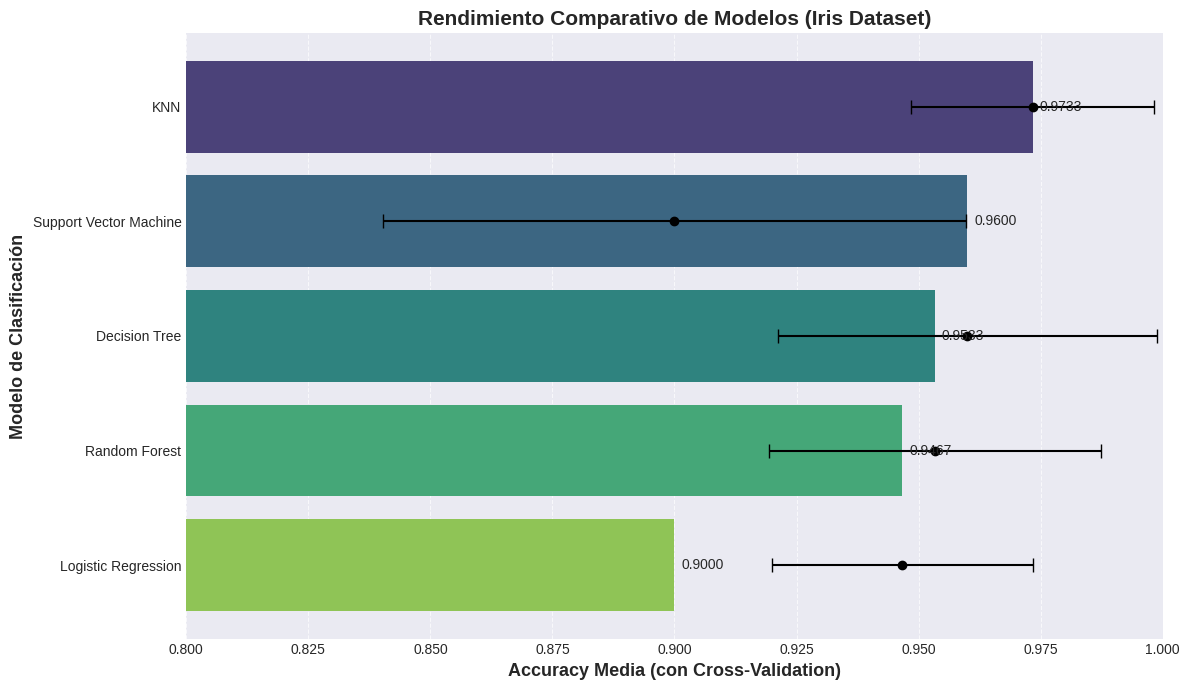


💡 INTERPRETACIÓN:
   • Los modelos se clasifican por su accuracy promedio obtenido mediante cross-validation.
   • Las barras horizontales muestran la desviación estándar, indicando la estabilidad del modelo.
   • Un accuracy alto y una desviación estándar baja son deseables.


In [35]:
import matplotlib.container

fig, ax = plt.subplots(figsize=(12, 7))

# sns.barplot returns the Axes object when 'ax' is provided. The BarContainer is added to ax.containers
sns.barplot(x='Accuracy Media (CV)', y='Modelo', data=df_results, palette='viridis', ax=ax, hue='Modelo', legend=False)

# Añadir barras de error para la desviación estándar
for i, row in df_results.iterrows():
    ax.errorbar(row['Accuracy Media (CV)'], i, xerr=row['Desviación Std (CV)'], fmt='o', color='black', capsize=5)

ax.set_xlabel('Accuracy Media (con Cross-Validation)', fontsize=13, fontweight='bold')
ax.set_ylabel('Modelo de Clasificación', fontsize=13, fontweight='bold')
ax.set_title('Rendimiento Comparativo de Modelos (Iris Dataset)', fontsize=15, fontweight='bold')
ax.set_xlim([0.8, 1.0])
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Añadir etiquetas de valor
# Iterate through containers to find the BarContainer and label it
for container in ax.containers:
    if isinstance(container, matplotlib.container.BarContainer):
        ax.bar_label(container, fmt='%.4f', fontsize=10, padding=5)

plt.tight_layout()
plt.show()

print("\n💡 INTERPRETACIÓN:")
print("   • Los modelos se clasifican por su accuracy promedio obtenido mediante cross-validation.")
print("   • Las barras horizontales muestran la desviación estándar, indicando la estabilidad del modelo.")
print("   • Un accuracy alto y una desviación estándar baja son deseables.")

## 10. Visualizaciones 3D Impactantes e Interactivas

Para llevar el análisis a otro nivel y visualizar la separabilidad de las clases en un espacio tridimensional, vamos a crear dos gráficos 3D interactivos. Esto nos dará una perspectiva "super chula" y muy intuitiva de la estructura de nuestros datos.

In [36]:
import plotly.express as px

print("✨ Generando gráfico 3D interactivo con características originales...")

# Crear un DataFrame para Plotly con las características y las etiquetas de especie
df_plot_3d = X.copy()
df_plot_3d['Species'] = y_labels

# Seleccionar tres características para el plot 3D
# Elegimos las características del pétalo y la longitud del sépalo por su mayor poder de separación
fig_3d_features = px.scatter_3d(
    df_plot_3d,
    x='petal length (cm)',
    y='petal width (cm)',
    z='sepal length (cm)',
    color='Species',
    symbol='Species',
    color_discrete_map={'Setosa': 'blue', 'Versicolor': 'green', 'Virginica': 'red'},
    title='Dispersión 3D de Especies Iris (Características Originales)',
    labels={
        'petal length (cm)': 'Longitud del Pétalo (cm)',
        'petal width (cm)': 'Ancho del Pétalo (cm)',
        'sepal length (cm)': 'Longitud del Sépalo (cm)'
    }
)

fig_3d_features.update_layout(
    scene=dict(
        xaxis_title='Longitud del Pétalo (cm)',
        yaxis_title='Ancho del Pétalo (cm)',
        zaxis_title='Longitud del Sépalo (cm)'
    ),
    height=700,
    width=900
)

fig_3d_features.show()

print("✅ Gráfico 3D de características originales generado.")

✨ Generando gráfico 3D interactivo con características originales...


✅ Gráfico 3D de características originales generado.


In [37]:
from sklearn.decomposition import PCA
import plotly.express as px
import pandas as pd

print("✨ Generando gráfico 3D interactivo con Componentes Principales (PCA)...")

# Asegurarse de que los datos estén escalados antes de PCA
# Ya usamos X_scaled previamente, pero se recalcula para claridad
scaler_pca = StandardScaler()
X_scaled_pca = scaler_pca.fit_transform(X)

# Aplicar PCA para reducir a 3 componentes
pca = PCA(n_components=3)
pca_components = pca.fit_transform(X_scaled_pca)

# Crear un DataFrame para Plotly con los componentes PCA y las etiquetas de especie
df_pca_3d = pd.DataFrame(
    data=pca_components,
    columns=['Principal Component 1', 'Principal Component 2', 'Principal Component 3']
)
df_pca_3d['Species'] = y_labels

fig_3d_pca = px.scatter_3d(
    df_pca_3d,
    x='Principal Component 1',
    y='Principal Component 2',
    z='Principal Component 3',
    color='Species',
    symbol='Species',
    color_discrete_map={'Setosa': 'blue', 'Versicolor': 'green', 'Virginica': 'red'},
    title='Dispersión 3D de Especies Iris (Componentes Principales)',
    labels={
        'Principal Component 1': f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)',
        'Principal Component 2': f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)',
        'Principal Component 3': f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)'
    }
)

fig_3d_pca.update_layout(
    scene=dict(
        xaxis_title=f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)',
        yaxis_title=f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)',
        zaxis_title=f'Principal Component 3 ({pca.explained_variance_ratio_[2]*100:.1f}%)'
    ),
    height=700,
    width=900
)

fig_3d_pca.show()

print("✅ Gráfico 3D de Componentes Principales (PCA) generado.")

✨ Generando gráfico 3D interactivo con Componentes Principales (PCA)...


✅ Gráfico 3D de Componentes Principales (PCA) generado.


In [44]:
import plotly.express as px
import pandas as pd

print("✨ Generando gráfico interactivo de Coordenadas Paralelas...")

# Crear un DataFrame con las características y las etiquetas de especie para Plotly
df_parallel = X.copy()
df_parallel['target_id'] = y # Añadir la columna numérica para colorear
df_parallel['Species_label'] = y_labels # Mantener las etiquetas de texto para la leyenda si es necesario

# Mapeo de colores para las clases numéricas - este mapa ya no se usará directamente como argumento
# color_map = {0: 'blue', 1: 'green', 2: 'red'}

fig_parallel = px.parallel_coordinates(
    df_parallel,
    color="target_id", # Usar la columna numérica para colorear
    dimensions=iris.feature_names, # Solo las características para los ejes
    title='Gráfico de Coordenadas Paralelas del Dataset Iris',
    labels={
        "sepal length (cm)": "Longitud Sépalo",
        "sepal width (cm)": "Ancho Sépalo",
        "petal length (cm)": "Longitud Pétalo",
        "petal width (cm)": "Ancho Pétalo",
        "target_id": "Especie" # Etiqueta para la leyenda del color
    }
    # color_discrete_map=color_map, # Este argumento no es válido para parallel_coordinates
    # hover_name="Species_label" # Este argumento tampoco es válido para parallel_coordinates
)

fig_parallel.update_layout(
    height=600,
    width=1000
)

fig_parallel.show()

print("✅ Gráfico de Coordenadas Paralelas generado.")

print("\n💡 INTERPRETACIÓN:")
print("   • Cada línea representa una flor individual del dataset.")
print("   • El color de la línea indica la especie a la que pertenece esa flor.")
print("   • Puedes observar cómo las diferentes especies tienden a agruparse en ciertos rangos para cada característica.")
print("   • La interactividad te permite arrastrar los rangos en cada eje para filtrar y destacar patrones específicos por especie.")
print("   • Notarás cómo las Setosas (generalmente un color distinto) forman un grupo muy compacto y separado en la mayoría de las características.")

✨ Generando gráfico interactivo de Coordenadas Paralelas...


✅ Gráfico de Coordenadas Paralelas generado.

💡 INTERPRETACIÓN:
   • Cada línea representa una flor individual del dataset.
   • El color de la línea indica la especie a la que pertenece esa flor.
   • Puedes observar cómo las diferentes especies tienden a agruparse en ciertos rangos para cada característica.
   • La interactividad te permite arrastrar los rangos en cada eje para filtrar y destacar patrones específicos por especie.
   • Notarás cómo las Setosas (generalmente un color distinto) forman un grupo muy compacto y separado en la mayoría de las características.


---

## 📚 Referencias y recursos adicionales

Scikit-learn Documentation: Cross-validation (Referencia principal para la implementación).

UCI Machine Learning Repository: Iris Dataset (Fuente original del dataset).

Hastie, T., Tibshirani, R., & Friedman, J. (2009). The Elements of Statistical Learning (Referencia teórica fundamental sobre Cross-Validation).

Blog de Telefónica I+D (España): Referencias y casos de uso en el ámbito de la IA y el Machine Learning.

Datatons (España): Comunidad y recursos en español de Data Science y Machine Learning.

IEEE Computer Society (Web española): Artículos y congresos académicos que abordan la aplicación de KNN y CV en diversos campos.

**Nota:** Este notebook fue desarrollado como parte del Caso Práctico 2 de la asignatura Ciencia de Datos, demostrando la implementación y ventajas de cross-validation en modelos de clasificación.